# Topic Modeling

In this project, we explore the hidden structures of 100 IMDB movies based on their synopses content. We summerize the machine learning flow in the table below.

| Stage               | Technique                                                                                       |
|---------------------|-------------------------------------------------------------------------------------------------|
| Problem statement   | Unsupervised classification on given movie synopses by NLP                                      |
| Data preprocessing  | Tokenization and stemming                                                                       |
| Feature engineering | Term frequency-inverse document frequency (TF-IDF)                                              |
| Model training      | K-means clustering for document clustering Latent Dirichlet Allocation (LDA) for topic modeling |
| Evaluation          | NA                                                                                                 |
| Result              | PCA and t-SNE dimension reduction to 2D visualization                                           |

The input dataset is a collection of synopses for [IMDB Top 100 Greatest Movies of All Time](https://www.imdb.com/list/ls055592025/). The synopses content are combined texts collected from both Wikipedia and IMDB. Each synopsis, termed as a document, is encoded by vector denoting the weight of tokens, which can represent a word or word collection formulated by Bag-of-words model and N-gram model. For each token, its weight defined by both term frequency and inverse document frequency (TF-IDF). Then each document can vectorized by the distribution of words in the feature engineering stage.

To model the relationship between movies, we first apply K-means to do document clustering. 100 Movies are split into 5 clusters in to get rough idea about how they are distributed. By both PCA and t-SNE 2-dimensional visualization, we notice that movies are roughly dispersed toward 3 directions. 

Furthermore, we move on to more sophisticated topic modeling. We adopt Latent Dirichlet Allocation (LDA) to include semantic relation and extract hidden topics. From t-SNE visualizations, we conclude LDA is helpful classify these 100 movies into 3 major topics. 

<ul>
<li>[LINK 1: Document clustering by K-means + PCA visualization](#Visualization-of-k-means-clustering-by-PCA-dimension-reduction)
<li>[LINK 2: Document clustering by K-means + t-SNE visualization](#Visualization-of-k-means-clustering-by-t-SNE-dimension-reduction)   
<li>[LINK 3: Topic modeling by LDA + PCA visualization](#Visualization-of-LDA-topic-modeling-by-PCA-dimension-reduction)
<li>[LINK 4: Topic modeling by LDA + t-SNE visulization](## Visualization of LDA topic modeling by t-SNE dimension reduction)
</ul>


## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Vectorize Documents by TF-IDF](#Part-2:-Vectorize-Documents-by-TF-IDF)
<li>[Part 3: K-means Document Clustering](#Part-3:-K-means-Document-Clustering)
<li>[Part 4: Topic Modeling - Latent Dirichlet Allocation](#Part-4:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import pandas as pd
import nltk
import re, os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

#### Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [3]:
#import three lists: titles and wikipedia synopses
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = [i for i in range(len(titles))]

# Part 2: Vectorize Documents by TF-IDF

### Part 2.1: Preprocessing words

#### Define stop words

In [4]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["john", "george", "paul", "tom", "josh", "robert", "george", "mr."])
stopwords.extend(["'s", "n't", "ii", "'ll"])

print ('We use {} stop-words from nltk library.'.format(str(len(stopwords))))
print ('First ten stop-words are {}'.format(stopwords[:10]))

We use 191 stop-words from nltk library.
First ten stop-words are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


#### Define tokeninig and stemming funciton. Stemming can be turned off if run_stemming is False

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text, run_stemming=True):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
  
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    if run_stemming:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

#### Tokenize and stem the synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization_and_stemming(i, False)
    docs_tokenized.extend(tokenized_results)

# This dict can recover the stemmed word to its original form. {stemmed word: original word}
vocab_frame_dict = {docs_stemmed[x]: docs_tokenized[x] for x in range(len(docs_stemmed))}

## Part 2.1 TF-IDF vectorization

In [7]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                              min_df=0.2, stop_words=stopwords,
                              use_idf=True, 
                              tokenizer=tokenization_and_stemming, 
                              ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses
# Save the terms identified by TF-IDF. They are words satisfying max_df and min_df condition in TF-IDF model
tf_selected_words = tfidf_model.get_feature_names() # function to convert number to word
print ("There are {} synoposes and {} terms ".format(tfidf_matrix.shape[0], tfidf_matrix.shape[1]))
# tfidf_model.get_params()  stores model info
# tfidf_model.vocabulary_   stores a 1-gram, 2-gram and 3-gram

There are 100 synoposes and 585 terms 


# Part 3: K-means Document Clustering

## Part 3.1 Set and train K-means model

In [8]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=325)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## Part 3.1 Analyze K-means Result

#### Column cluster stores the k-means clustering result

In [9]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
3,0,The Godfather,3
1,1,The Shawshank Redemption,1
3,2,Schindler's List,3
1,3,Raging Bull,1
1,4,Casablanca,1
1,5,One Flew Over the Cuckoo's Nest,1
3,6,Gone with the Wind,3
2,7,Citizen Kane,2
2,8,The Wizard of Oz,2
2,9,Titanic,2


#### Count and average rank for each cluster

In [10]:
df_cluster_summary = frame['cluster'].value_counts().sort_index().to_frame()
df_cluster_summary.columns = ['count']
df_cluster_summary['avg rank'] = frame['rank'].groupby(frame['cluster']).mean().sort_index()

print('{} movies are grouped into {} clusters'.format(tfidf_matrix.shape[0], num_clusters))
df_cluster_summary

100 movies are grouped into 5 clusters


,count,avg rank
0,18,44.222222
1,51,52.411765
2,7,32.428571
3,19,50.263158
4,5,59.800000


#### Key words and movies under each cluster (REMOVE %%capture TO SEE THE OUTPUT)

In [11]:
%%capture
print ("<Document clustering result by K-means>")
n_top_words = 6 # number of words to show here

#km.cluster_centers_ denotes the coordinates of each centroids. By reverser argsort, we can idenfity top few components
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_keywords_summary = {}
for i in range(num_clusters):

    cluster_keywords_summary[i] = []
    for ind in order_centroids[i, : n_top_words]: # Only show top n_top_words words with n words per cluster
        converted = [vocab_frame_dict[word_piece] for word_piece in tf_selected_words[ind].split() ]
        cluster_keywords_summary[i].append(" ".join(converted))
    
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    
    print ("Cluster {} contains words like:\n{}".format(i, cluster_keywords_summary[i]))  
    print ("Cluster {} contain {} movies. Their titles are: \n{}\n".format(i, len(cluster_movies), cluster_movies))     

## 3.2. Plot K-means Result

#### Define a handy function to visualize the clustering result

In [12]:
def dim_red_visualization(matrix, predicted_cluster, cluster_label, movie_title, mode='pca', tsne_perplexity=40):
    %matplotlib inline
    """
    Reduce NxM matrix to Nx2 and visualize it
    arg: matrix: MxN numpy matrix. M movies and N topics
         predicted_cluster: predicted cluster type from model. len(predicted_cluster) = M
         cluster_label: list of labels. Size = M
         movie_title: list of movie. Size = N
         mode: 'pca' or 'tsne' for dim reduction
    """
    from sklearn.manifold import TSNE

    dim_red_mode = mode #'pca'  # pca or tsne
    if dim_red_mode == 'pca':
        reduced_matrix = decomposition.PCA(n_components=2).fit_transform(matrix)
    elif dim_red_mode == 'tsne':
        reduced_matrix = TSNE(n_components=2, perplexity=tsne_perplexity, 
                              learning_rate=200, random_state=0).fit_transform(matrix)
    else:
        print('WRONG dimension reduction mode!!!')

    xs, ys = reduced_matrix[:, 0], reduced_matrix[:, 1]  # all x coordinates and all y coordinates

    # create data frame with PCA cluster results
    df = pd.DataFrame(dict(x=xs, y=ys, label=predicted_cluster, title=movie_title))
    groups = df.groupby(predicted_cluster)

    fig, ax = plt.subplots(figsize=(24, 12))
    for i, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_label[i], mec='none')

    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=12)
    
    ax.legend(numpoints=1, loc=4)  # show legend with only 1 point, position is right bottom.
    plt.show()

# Visualization of k-means clustering by PCA dimension reduction

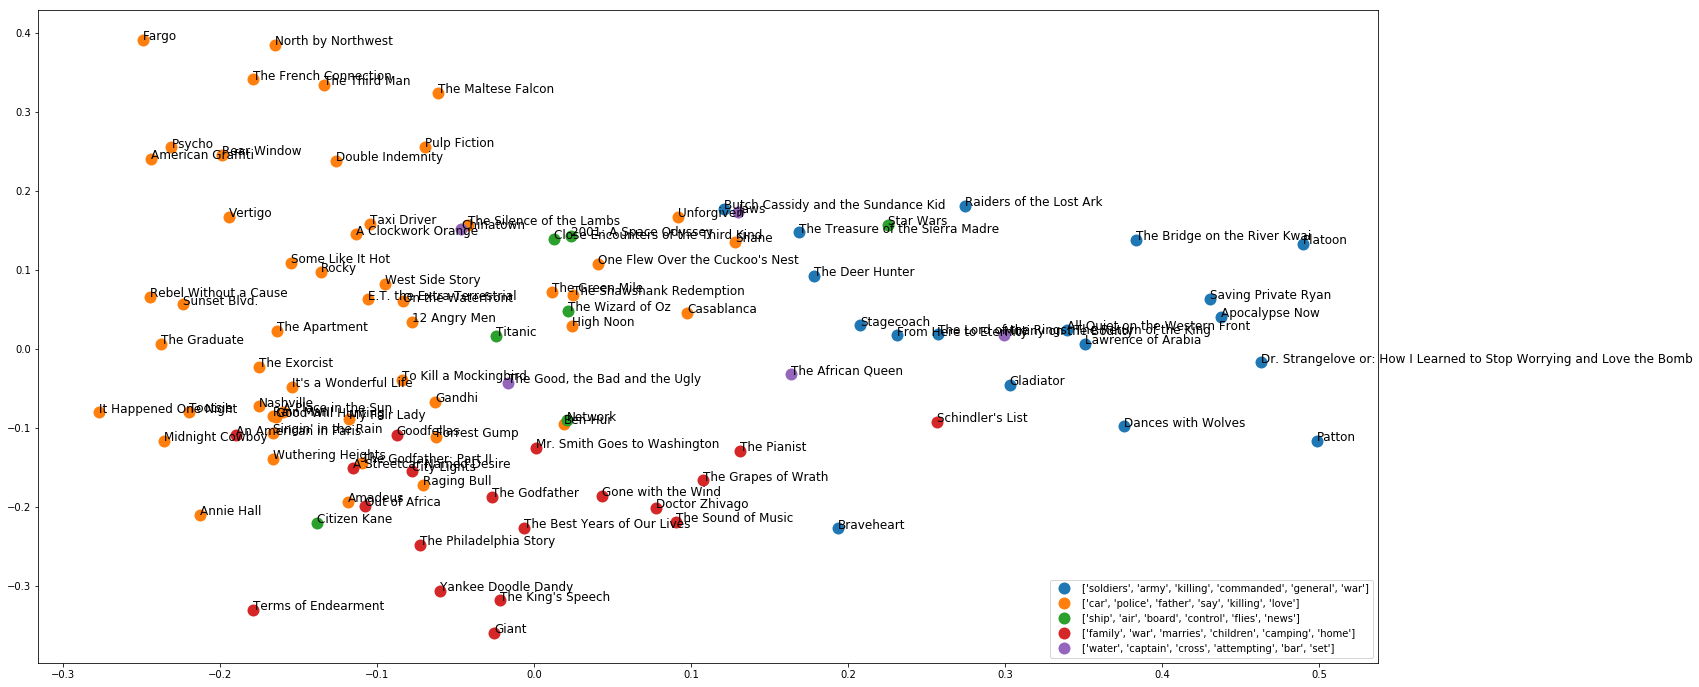

In [13]:
cluster_label = [cluster_keywords_summary[i] for i in range(num_clusters)]
dim_red_visualization(tfidf_matrix.toarray(), km.labels_.tolist(), cluster_label, titles, mode='pca')

# Visualization of k-means clustering by t-SNE dimension reduction

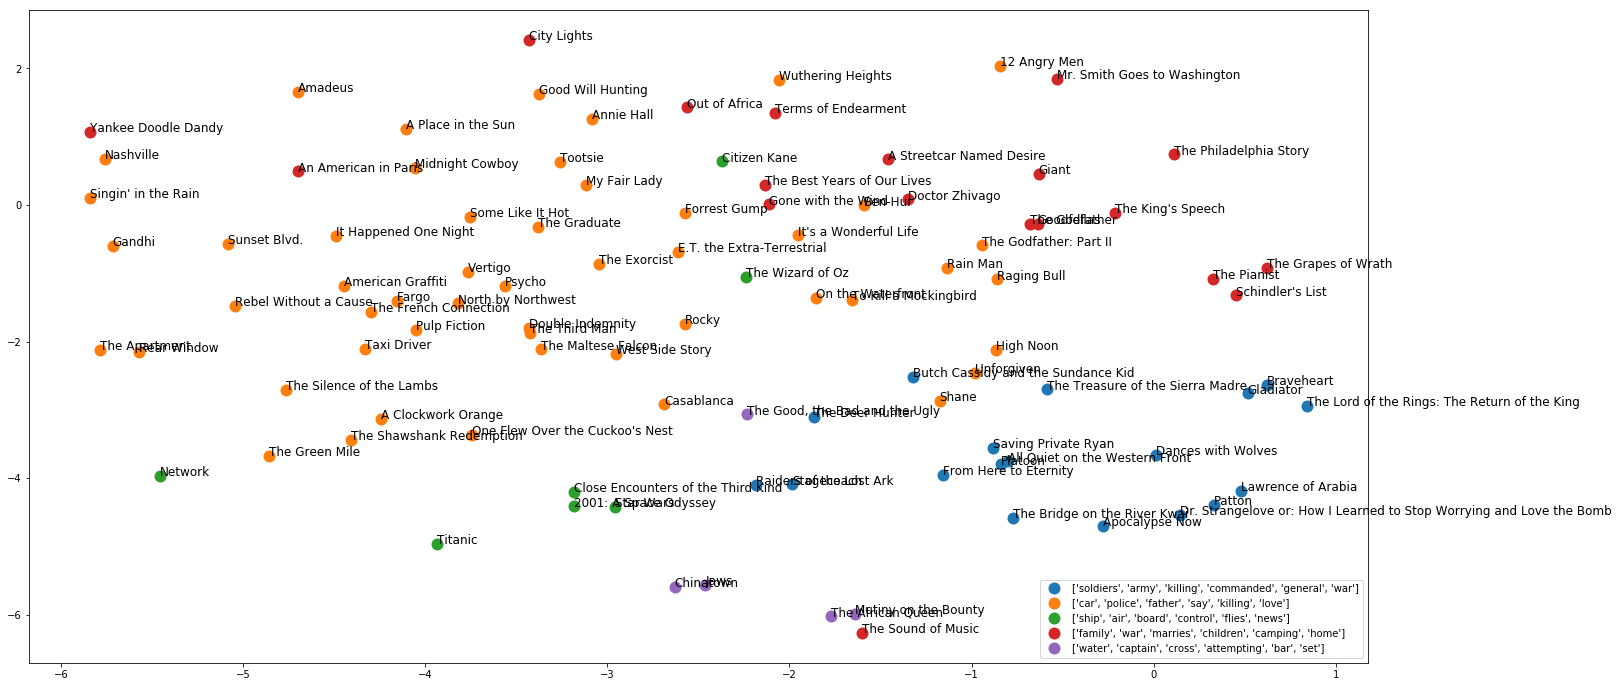

In [14]:
cluster_label = [cluster_keywords_summary[i] for i in range(num_clusters)]
dim_red_visualization(tfidf_matrix.toarray(), km.labels_.tolist(), cluster_label, titles, mode='tsne', tsne_perplexity=40)

# Part 4: Topic Modeling - Latent Dirichlet Allocation

#### Create a term frequency matrix based on the selected words by tf-idf (tf_selected_words)

In [15]:
# Prepare the term frequency matrix for LDA pacakge
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

#### Run LDA either by LDA package or sklearn

In [44]:
lda_package = 'sklearn' # lda or sklearn
num_topic = 3

if lda_package == 'sklearn':
    tfidf_matrix_lda = (tfidf_matrix) * 100
    tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

    model = decomposition.LatentDirichletAllocation(n_components=num_topic, learning_method='online', random_state=5)
    model.fit(feature_matrix_synopses_tf)
    topic_word = model.components_
    doc_topic = model.transform(feature_matrix_synopses_tf)
elif lda_package == 'lda':
    model = lda.LDA(n_topics=num_topic, n_iter=500, random_state=1)
    model.fit(feature_matrix_synopses_tf)
    # Note: "model.doctopic_" is of shape (num_of_documents, n_topics)
    #       "model.topic_word" is of shape (n_topics, num_of_selected_words)
    topic_word = model.topic_word_
    doc_topic = model.doc_topic_

#### Key words and movies under each cluster (REMOVE %%capture TO SEE THE OUTPUT)

In [49]:
%%capture
n_top_words = 6

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top n_top_words
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-(n_top_words+1):-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

topic_doc_dict = {}

print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])

for i in topic_doc_dict:
    print("Cluster {} contains words like: \n{}".format(i, topic_keywords_list[i]))  
    print("Cluster {} contain {} movies. Their titles are: \n{}\n".format(i, len(topic_doc_dict[i]), topic_doc_dict[i]))

# Visualization of LDA topic modeling by PCA dimension reduction

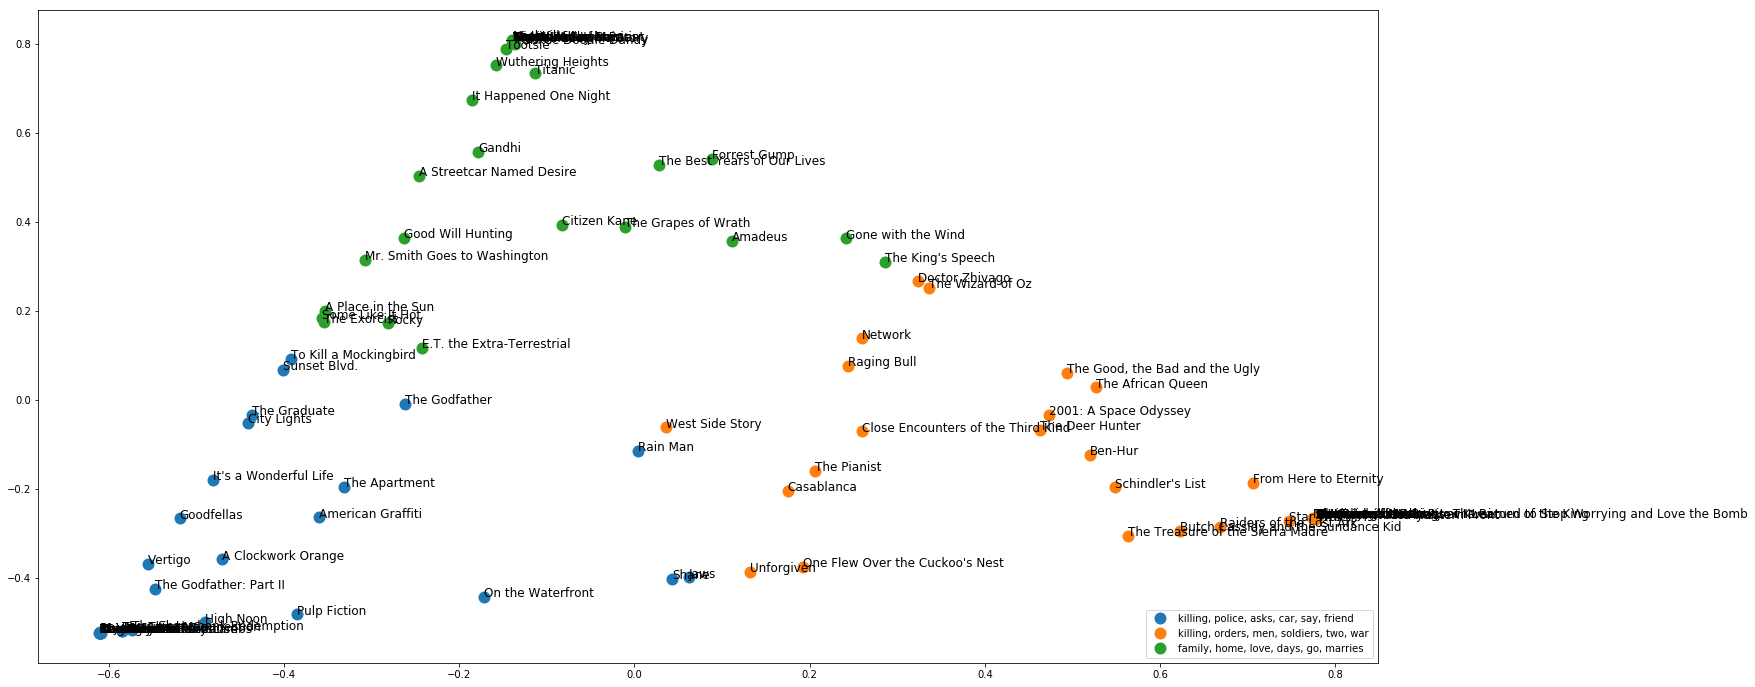

In [46]:
cluster_names = []
for i in range(num_topic):
    cluster_names.append(", ".join(topic_keywords_list[i]))
    
cluster_prediction = [item.argmax() for item in doc_topic]        
dim_red_visualization(doc_topic, cluster_prediction, cluster_names, titles, mode='pca')

# Visualization of LDA topic modeling by t-SNE dimension reduction

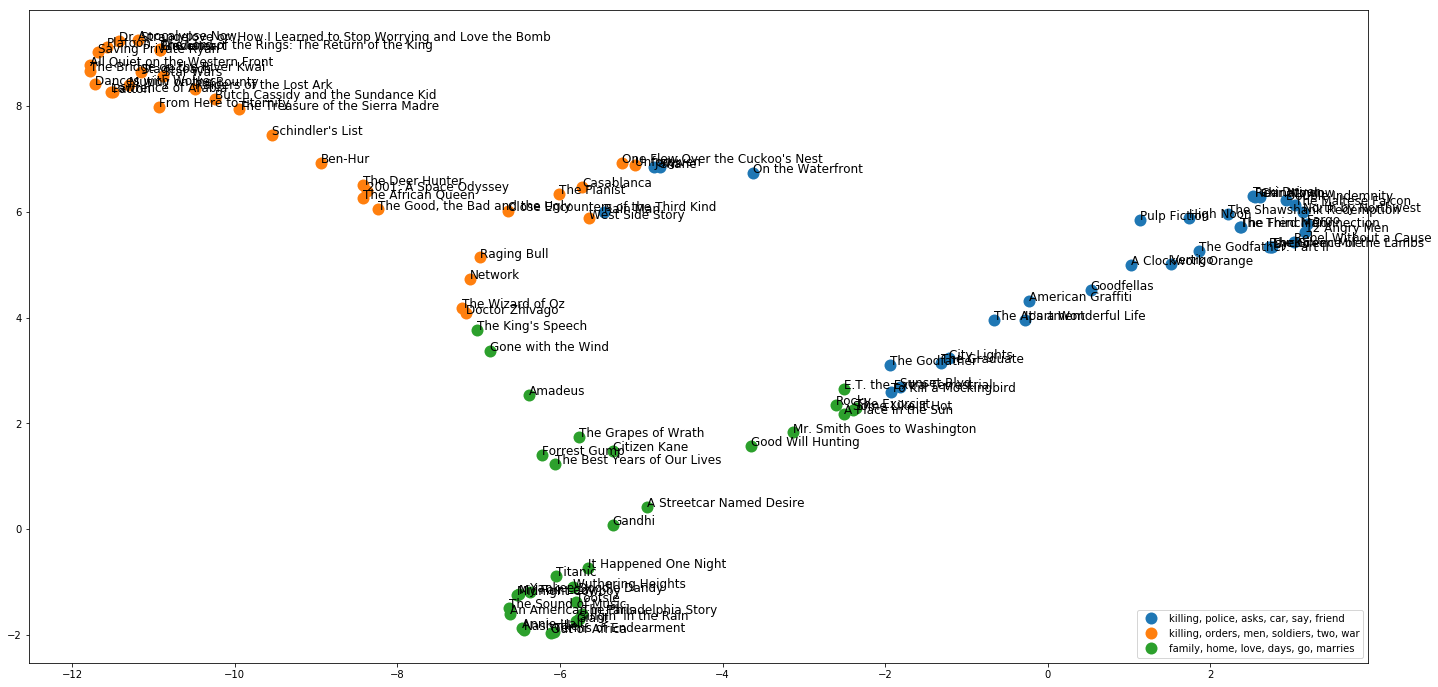

In [48]:
dim_red_visualization(doc_topic, cluster_prediction, cluster_names, titles, mode='tsne', tsne_perplexity=20)

### Topics found by LDA
From the high-frequency words in each topic, we can roughly understand that blue for crime and action movies, orange for war movie and green for romance & family movies.